In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder


selected_columns = ['CustomerID', 'Start Year', 'Cleaned_Insured name', 'Policy Start Date', 'Policy End Date', 'Reg no ',
       'MANUFACTURER/Make', 'model', 'variant', 'Fuel Type', 'RTO Location ',
       'Product name ', 'Product name  2', 'biztype', 'Renewal Type', 'age',
       'Vehicle Segment', 'Number of Vehicles', 'Number of Policies',
       'Total Premium Payable (Overall)', 'Total OD Premium (Overall)',
       'Total TP Premium (Overall)', 'Total Add on Premium (Overall)',
       'Total GST (Overall)', 'Average Discount (Overall)',
       'Average NCB % Previous Year (Overall)', 'Number of Claims',
       'Number of Declines', 'New Branch Name  2', 'Policy Status', 'Not Renewed', 
       'Renewed','Open', 'Renewal Rate', 'Churn Label', 'New Customer', 'Customer Tenure ']

data = pd.read_excel('Actual data (East).xlsx')
data = data[selected_columns]

# Remove rows where 'Status' contains 'Open'
data = data[~data['Policy Status'].str.contains('Open', case=False, na=False)]

data = data[data['Policy Status'].str.contains('Renewed|Not Renewed', case=False, na=False)]

data['Churn Label'] = data['Churn Label'].apply(lambda x: 1 if x == 'Yes' else 0)

for column in data.columns:
    if data[column].dtype == 'object':
        data[column] = data[column].fillna('missing')
    else:
        data[column] = data[column].fillna(0)

date_columns = ['Policy Start Date', 'Policy End Date']

for col in date_columns:
    data[col] = pd.to_datetime(data[col], errors='coerce')

# Extract year, month, and day as separate features for all date columns
new_date_cols = {}
for col in date_columns:
    new_date_cols[f'{col}_YEAR'] = data[col].dt.year
    new_date_cols[f'{col}_MONTH'] = data[col].dt.month
    new_date_cols[f'{col}_DAY'] = data[col].dt.day

data = pd.concat([data, pd.DataFrame(new_date_cols)], axis=1)

most_recent_year = data['Policy Start Date_YEAR'].max()

test_data = data[(data['Policy Start Date_YEAR'] == most_recent_year) & 
                 (data['Policy Start Date_MONTH'] >= 6)]

train_data = data[~((data['Policy Start Date_YEAR'] == most_recent_year) & 
                    (data['Policy Start Date_MONTH'] >= 6))]

data = data.drop(columns=date_columns)

leaking_features = [
    'Not Renewed', 'Renewed','Open', 'Renewal Rate', 'Policy Status'
]

features = [col for col in data.columns if col not in leaking_features + ['Churn Label']]

X_train = train_data[features]
y_train = train_data['Churn Label']

X_test = test_data[features]
y_test = test_data['Churn Label']

In [2]:
from imblearn.over_sampling import RandomOverSampler

# Initialize RandomOverSampler
ros = RandomOverSampler(random_state=42)

# Apply Random Oversampling to the training data
X_train, y_train = ros.fit_resample(X_train, y_train)

In [4]:
# Group by year and status to count occurrences in the training data
train_status_yearwise = train_data.groupby(['Policy Start Date_YEAR', 'Churn Label']).size().reset_index(name='Count')

# Group by year and status to count occurrences in the testing data
test_status_yearwise = test_data.groupby(['Policy Start Date_YEAR', 'Churn Label']).size().reset_index(name='Count')

# Print the results
print("Year-wise Status Counts in Training Data:")
print(train_status_yearwise)

print("\nYear-wise Status Counts in Testing Data:")
print(test_status_yearwise)

# Count the occurrences of 0 and 1 in the 'Status' column for train and test data
train_status_count = y_train.value_counts()
test_status_count = y_test.value_counts()

# Print the results
print("Training Data Status Counts:")
print(train_status_count)

print("\nTesting Data Status Counts:")
print(test_status_count)

Year-wise Status Counts in Training Data:
   Policy Start Date_YEAR  Churn Label  Count
0                    2019            0      1
1                    2020            0     28
2                    2020            1    529
3                    2021            0    179
4                    2021            1      2
5                    2022            0  10342
6                    2022            1  27146
7                    2023            0   4224
8                    2023            1  13040

Year-wise Status Counts in Testing Data:
   Policy Start Date_YEAR  Churn Label  Count
0                    2023            0   1045
1                    2023            1   9473
Training Data Status Counts:
Churn Label
1    40717
0    40717
Name: count, dtype: int64

Testing Data Status Counts:
Churn Label
1    9473
0    1045
Name: count, dtype: int64


In [5]:
# Group by year and status to count occurrences in the training data
train_status_monthwise = train_data.groupby(['Policy Start Date_YEAR', 'Policy Start Date_MONTH', 'Churn Label']).size().reset_index(name='Count')

# Group by year and status to count occurrences in the testing data
test_status_monthwise = test_data.groupby(['Policy Start Date_YEAR', 'Policy Start Date_MONTH', 'Churn Label']).size().reset_index(name='Count')

# Print the results
print("Year-wise Status Counts in Training Data:")
print(train_status_monthwise)

print("\nYear-wise Status Counts in Testing Data:")
print(test_status_monthwise)

# Count the occurrences of 0 and 1 in the 'Status' column for train and test data
train_status_count = y_train.value_counts()
test_status_count = y_test.value_counts()

# Print the results
print("Training Data Status Counts:")
print(train_status_count)

print("\nTesting Data Status Counts:")
print(test_status_count)

Year-wise Status Counts in Training Data:
    Policy Start Date_YEAR  Policy Start Date_MONTH  Churn Label  Count
0                     2019                       10            0      1
1                     2020                        1            0      4
2                     2020                        1            1    139
3                     2020                        2            0      6
4                     2020                        2            1    123
..                     ...                      ...          ...    ...
57                    2023                        3            1   3048
58                    2023                        4            0    813
59                    2023                        4            1   2548
60                    2023                        5            0    838
61                    2023                        5            1   2516

[62 rows x 4 columns]

Year-wise Status Counts in Testing Data:
   Policy Start Date_YEAR  Po

In [6]:
# Apply label encoding to categorical features for both train and test sets
for column in X_train.columns:
    if X_train[column].dtype == 'object':
        # Initialize and fit the LabelEncoder on the training data
        label_encoder = LabelEncoder()
        X_train[column] = label_encoder.fit_transform(X_train[column].astype(str))

        # Create a mapping dictionary from the LabelEncoder
        mapping_dict = {label: i for i, label in enumerate(label_encoder.classes_)}
        
        # Track the next unique integer for unseen values in the test set
        next_unique_value = [max(mapping_dict.values()) + 1]  

        # Encode the test data
        def encode_test_value(value):
            if value in mapping_dict:
                return mapping_dict[value]
            else:
                # Update the mapping_dict with a new unique value for unseen categories
                mapping_dict[value] = next_unique_value[0]
                next_unique_value[0] += 1
                return mapping_dict[value]

        # Apply the encoding to the test set
        X_test[column] = X_test[column].apply(encode_test_value)

C:\Users\Admin\AppData\Local\Temp\ipykernel_15044\1072933455.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[column] = X_test[column].apply(encode_test_value)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15044\1072933455.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test[column] = X_test[column].apply(encode_test_value)
C:\Users\Admin\AppData\Local\Temp\ipykernel_15044\1072933455.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using 

Test Accuracy: 0.6953793496862521
Test Log Loss: 0.5017882059907626
Test ROC AUC: 0.7775972709140104
Test Classification Report:
              precision    recall  f1-score   support

           0       0.21      0.73      0.32      1045
           1       0.96      0.69      0.80      9473

    accuracy                           0.70     10518
   macro avg       0.58      0.71      0.56     10518
weighted avg       0.88      0.70      0.76     10518

Class 0 Test Accuracy: 0.7349282296650718
Class 1 Test Accuracy: 0.6910165734191914
Train Accuracy: 0.8844340201881278
Train Log Loss: 0.2820923215687236
Train ROC AUC: 0.9476053009234287
Train Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88     40717
           1       0.87      0.90      0.89     40717

    accuracy                           0.88     81434
   macro avg       0.88      0.88      0.88     81434
weighted avg       0.88      0.88      0.88     81434



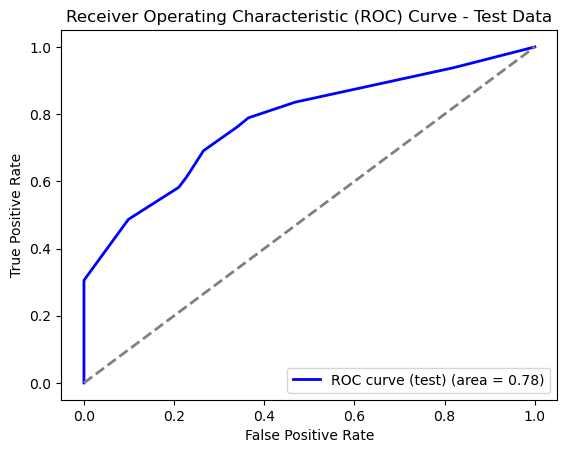

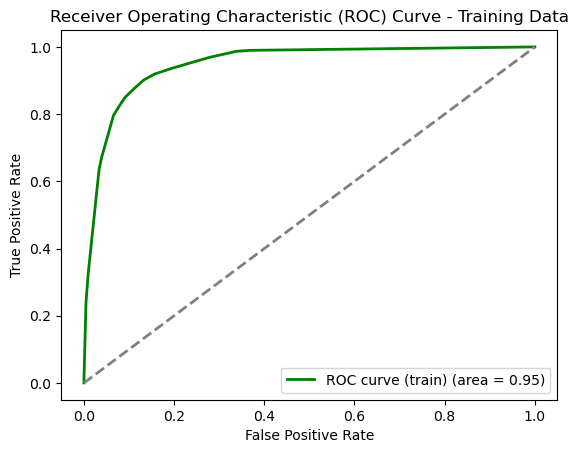

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42, max_depth=5)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8156493629967675
Test Log Loss: 6.644670462207469
Test ROC AUC: 0.5358222841346623
Test Classification Report:
              precision    recall  f1-score   support

           0       0.15      0.19      0.17      1045
           1       0.91      0.89      0.90      9473

    accuracy                           0.82     10518
   macro avg       0.53      0.54      0.53     10518
weighted avg       0.83      0.82      0.82     10518

Class 0 Test Accuracy: 0.18660287081339713
Class 1 Test Accuracy: 0.8850416974559274
Train Accuracy: 1.0
Train Log Loss: 2.2204460492503136e-16
Train ROC AUC: 1.0
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40717
           1       1.00      1.00      1.00     40717

    accuracy                           1.00     81434
   macro avg       1.00      1.00      1.00     81434
weighted avg       1.00      1.00      1.00     81434

Class 0 Train Accuracy: 1.

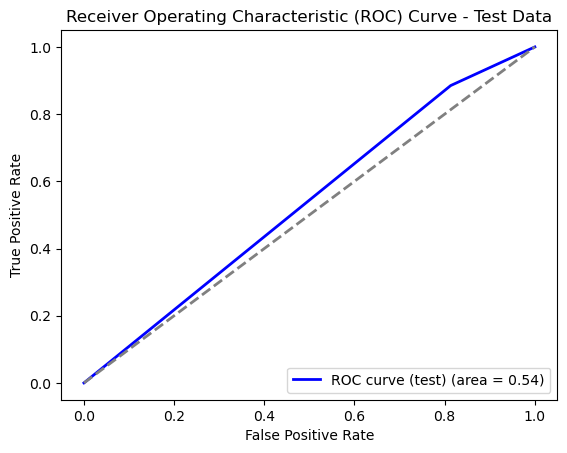

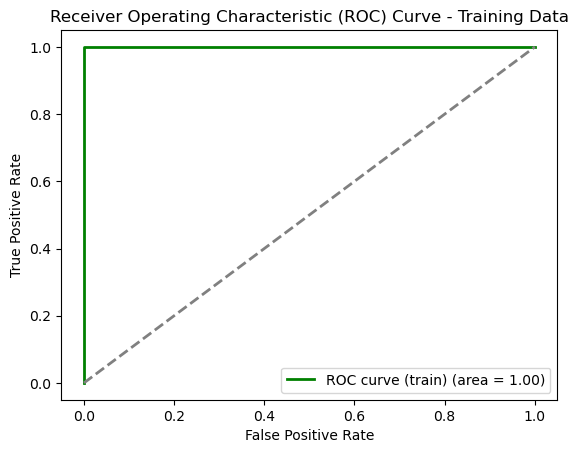

In [8]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree classifier
model = DecisionTreeClassifier(random_state=42)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.401312036508842
Test Log Loss: 0.7540421743959619
Test ROC AUC: 0.47076536335705055
Test Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.70      0.19      1045
           1       0.92      0.37      0.53      9473

    accuracy                           0.40     10518
   macro avg       0.51      0.54      0.36     10518
weighted avg       0.84      0.40      0.49     10518

Class 0 Test Accuracy: 0.7043062200956938
Class 1 Test Accuracy: 0.367887680776945
Train Accuracy: 0.8719208193138002
Train Log Loss: 0.3100293224295515
Train ROC AUC: 0.9319699823718037
Train Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.88      0.87     40717
           1       0.88      0.86      0.87     40717

    accuracy                           0.87     81434
   macro avg       0.87      0.87      0.87     81434
weighted avg       0.87      0.87      0.87     81434

C

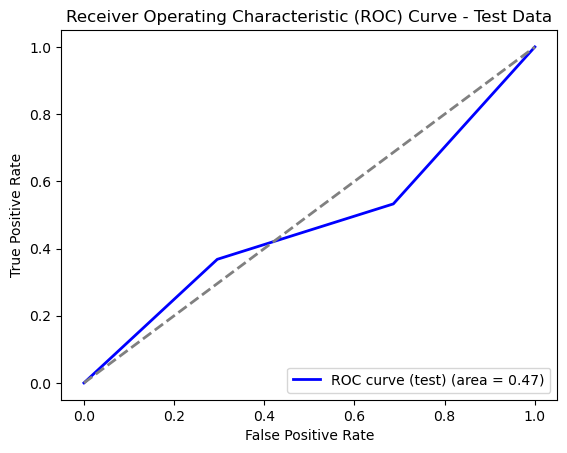

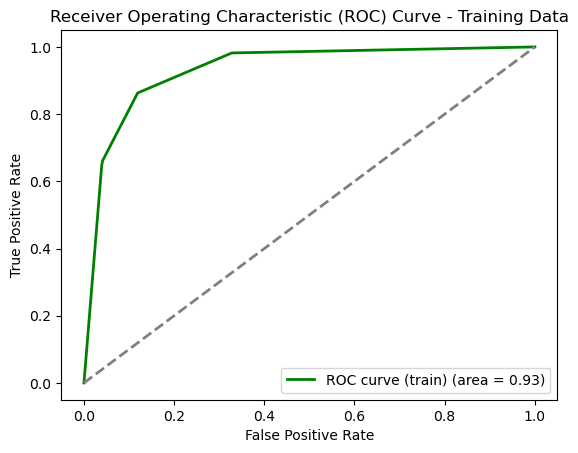

In [9]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, classification_report

model = DecisionTreeClassifier(
    random_state=42,
    max_depth=8,                
    min_samples_split=20,       
    min_samples_leaf=10,        
    max_leaf_nodes=50,          
    ccp_alpha=0.01              
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.12046016352918806
Test Log Loss: 1.2686870897215246
Test ROC AUC: 0.7007667725497346
Test Classification Report:
              precision    recall  f1-score   support

           0       0.10      1.00      0.18      1045
           1       0.99      0.02      0.05      9473

    accuracy                           0.12     10518
   macro avg       0.54      0.51      0.12     10518
weighted avg       0.90      0.12      0.06     10518

Class 0 Test Accuracy: 0.9971291866028709
Class 1 Test Accuracy: 0.0237517154016679
Train Accuracy: 0.6398555885747967
Train Log Loss: 0.5930981531078139
Train ROC AUC: 0.951017465054308
Train Classification Report:
              precision    recall  f1-score   support

           0       0.58      1.00      0.73     40717
           1       0.99      0.28      0.44     40717

    accuracy                           0.64     81434
   macro avg       0.79      0.64      0.59     81434
weighted avg       0.79      0.64      0.59     81434



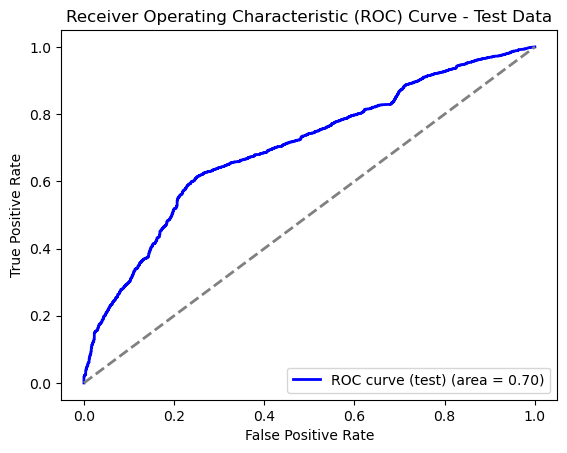

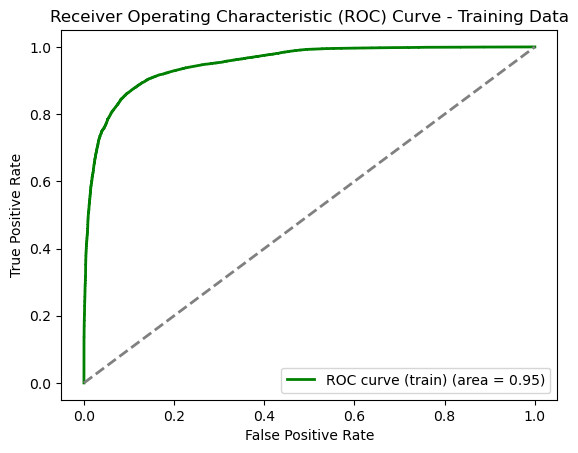

In [10]:
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    max_leaf_nodes=50,
    class_weight={0: 10, 1: 1},  
    random_state=42
)
# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8764023578627116
Test Log Loss: 0.39335998101888364
Test ROC AUC: 0.7328547465801823
Test Classification Report:
              precision    recall  f1-score   support

           0       0.31      0.19      0.24      1045
           1       0.91      0.95      0.93      9473

    accuracy                           0.88     10518
   macro avg       0.61      0.57      0.58     10518
weighted avg       0.85      0.88      0.86     10518

Train Accuracy: 0.9999877201169045
Train Log Loss: 0.03283913577057896
Train ROC AUC: 1.0
Train Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     40717
           1       1.00      1.00      1.00     40717

    accuracy                           1.00     81434
   macro avg       1.00      1.00      1.00     81434
weighted avg       1.00      1.00      1.00     81434



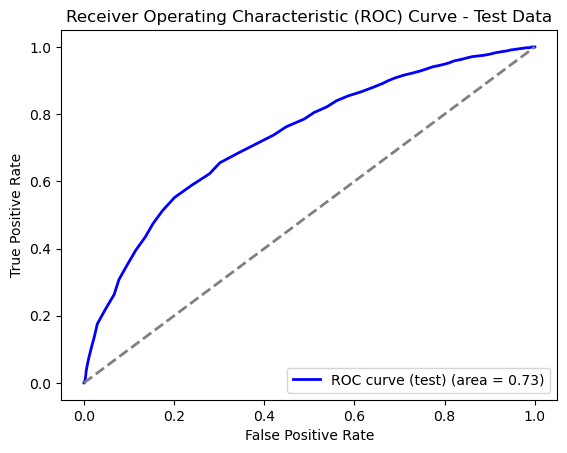

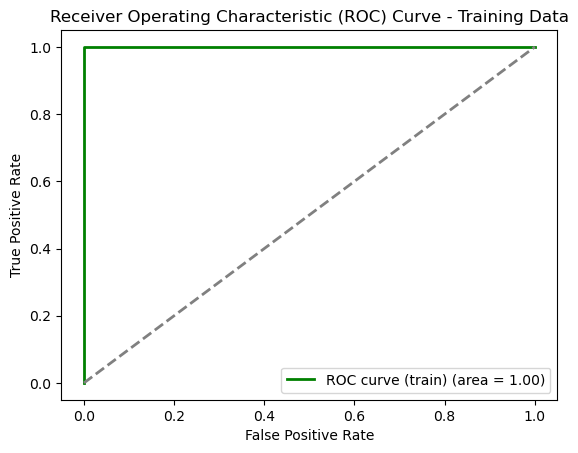

In [11]:
from sklearn.tree import DecisionTreeClassifier

# Initialize and train the Decision Tree classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.209260315649363
Test Log Loss: 1.0359256925403313
Test ROC AUC: 0.7161956646363853
Test Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.97      0.20      1045
           1       0.97      0.13      0.22      9473

    accuracy                           0.21     10518
   macro avg       0.54      0.55      0.21     10518
weighted avg       0.89      0.21      0.22     10518

Class 0 Test Accuracy: 0.9665071770334929
Class 1 Test Accuracy: 0.12572574685949542
Train Accuracy: 0.7947785937077879
Train Log Loss: 0.466806978804734
Train ROC AUC: 0.9521917647269533
Train Classification Report:
              precision    recall  f1-score   support

           0       0.72      0.98      0.83     40717
           1       0.96      0.61      0.75     40717

    accuracy                           0.79     81434
   macro avg       0.84      0.79      0.79     81434
weighted avg       0.84      0.79      0.79     81434

C

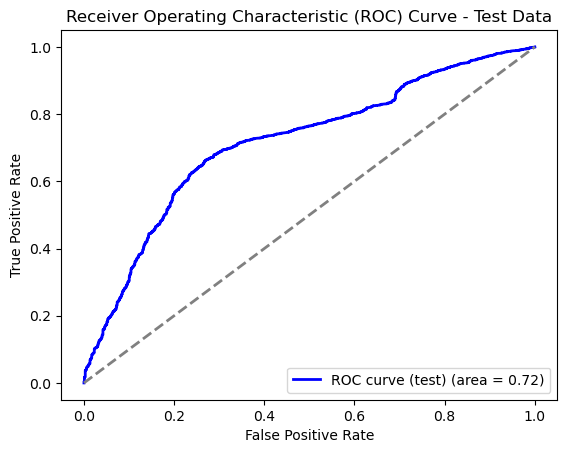

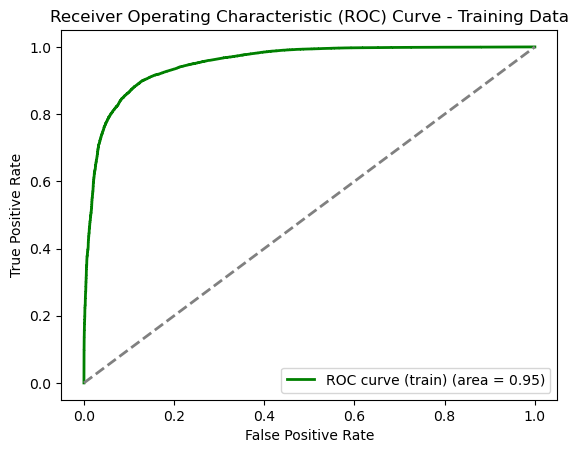

In [12]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier(
    n_estimators=100,
    max_depth=8,
    min_samples_split=20,
    min_samples_leaf=10,
    max_leaf_nodes=50,
    class_weight={0: 5, 1: 1},  
    random_state=42
)

from sklearn.metrics import confusion_matrix

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7885529568359003
Test Log Loss: 0.5570542524703815
Test ROC AUC: 0.6670900474125151
Test Classification Report:
              precision    recall  f1-score   support

           0       0.20      0.38      0.26      1045
           1       0.92      0.83      0.88      9473

    accuracy                           0.79     10518
   macro avg       0.56      0.61      0.57     10518
weighted avg       0.85      0.79      0.82     10518

Train Accuracy: 0.8846918977331336
Train Log Loss: 0.3391605412843804
Train ROC AUC: 0.950918557965351
Train Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.87      0.88     40717
           1       0.87      0.90      0.89     40717

    accuracy                           0.88     81434
   macro avg       0.89      0.88      0.88     81434
weighted avg       0.89      0.88      0.88     81434



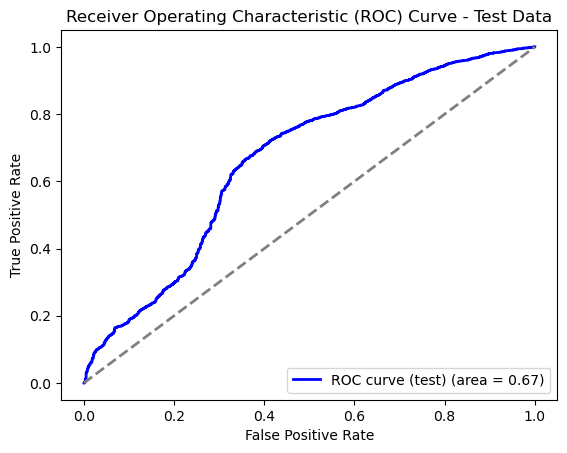

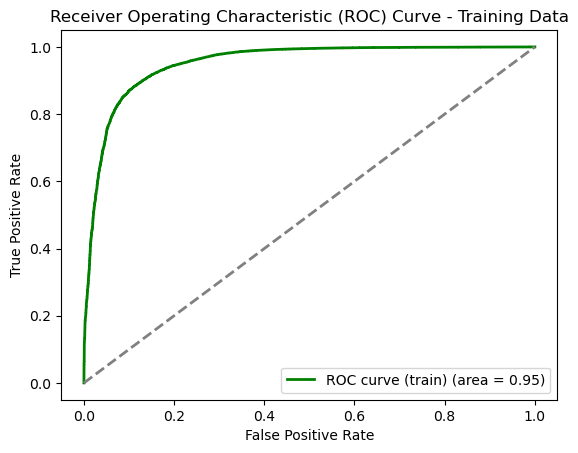

In [13]:
from sklearn.ensemble import RandomForestClassifier

# Random Forest model
model = RandomForestClassifier(
    n_estimators=100,             
    max_depth=8,                  
    min_samples_split=20,         
    min_samples_leaf=10,          
    max_leaf_nodes=50,            
    class_weight='balanced',      
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.1515497242821829
Test Log Loss: 1.1289111734332635
Test ROC AUC: 0.7045370953558767
Test Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.99      0.19      1045
           1       0.97      0.06      0.11      9473

    accuracy                           0.15     10518
   macro avg       0.54      0.52      0.15     10518
weighted avg       0.89      0.15      0.12     10518

Train Accuracy: 0.7249060588943194
Train Log Loss: 0.5095021740992707
Train ROC AUC: 0.9448117344332293
Train Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.98      0.78     40717
           1       0.96      0.47      0.63     40717

    accuracy                           0.72     81434
   macro avg       0.81      0.72      0.71     81434
weighted avg       0.81      0.72      0.71     81434



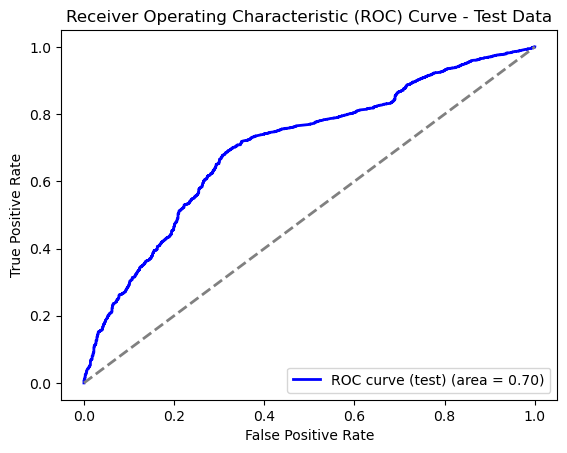

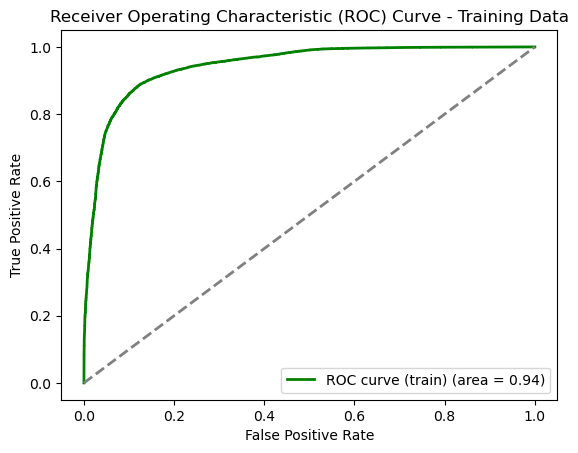

In [14]:
model = RandomForestClassifier(
    n_estimators=50,  
    max_depth=6,     
    min_samples_split=50,
    min_samples_leaf=20,
    max_leaf_nodes=30,
    class_weight={0: 5, 1: 1},
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\linear_model\_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Test Accuracy: 0.3988400836660962
Test Log Loss: 0.8546899749036602
Test ROC AUC: 0.6137492758315373
Test Classification Report:
              precision    recall  f1-score   support

           0       0.12      0.79      0.21      1045
           1       0.94      0.36      0.52      9473

    accuracy                           0.40     10518
   macro avg       0.53      0.57      0.36     10518
weighted avg       0.86      0.40      0.49     10518

Train Accuracy: 0.6646609524277329
Train Log Loss: 0.625527062633965
Train ROC AUC: 0.7098607263413235
Train Classification Report:
              precision    recall  f1-score   support

           0       0.67      0.65      0.66     40717
           1       0.66      0.68      0.67     40717

    accuracy                           0.66     81434
   macro avg       0.66      0.66      0.66     81434
weighted avg       0.66      0.66      0.66     81434



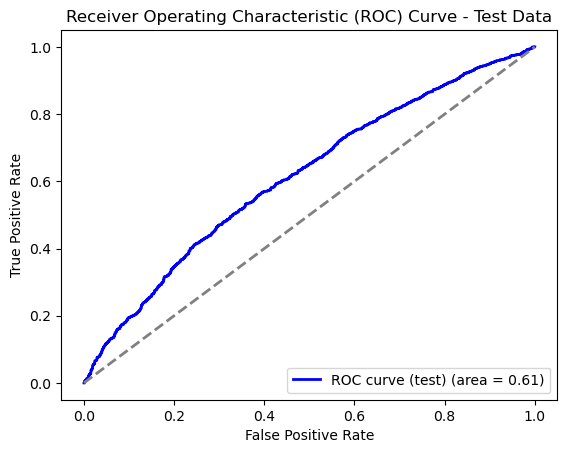

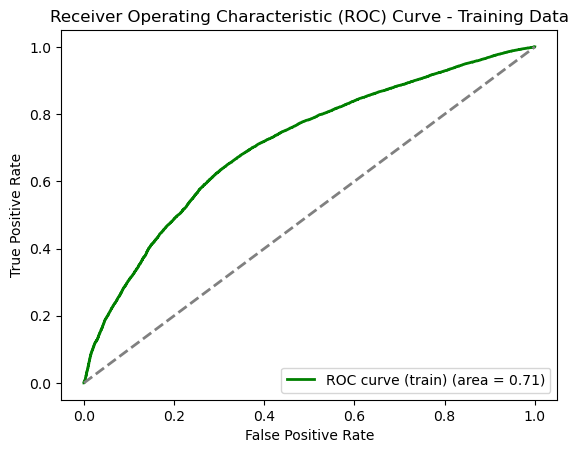

In [15]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# Initialize Logistic Regression model
model = LogisticRegression(
    max_iter=1000,   
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\svm\_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


Test Accuracy: 0.341604867845598
Test Log Loss: 0.688637503795487
Test ROC AUC: 0.4742456652172354
Test Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.77      0.19      1045
           1       0.92      0.29      0.45      9473

    accuracy                           0.34     10518
   macro avg       0.51      0.53      0.32     10518
weighted avg       0.84      0.34      0.42     10518

Train Accuracy: 0.5034997666822212
Train Log Loss: 0.6931542698927721
Train ROC AUC: 0.49962879177370395
Train Classification Report:
              precision    recall  f1-score   support

           0       0.50      0.58      0.54     40717
           1       0.50      0.43      0.46     40717

    accuracy                           0.50     81434
   macro avg       0.50      0.50      0.50     81434
weighted avg       0.50      0.50      0.50     81434



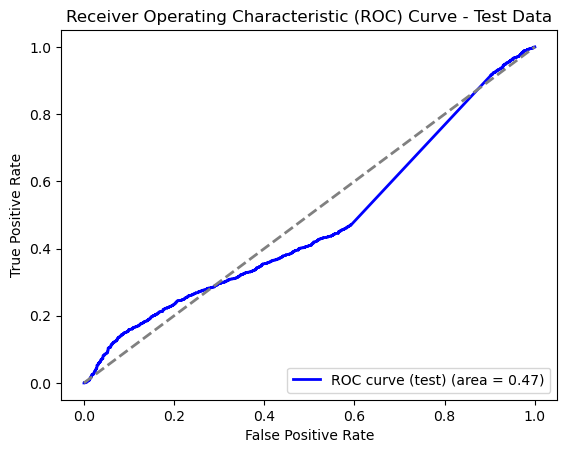

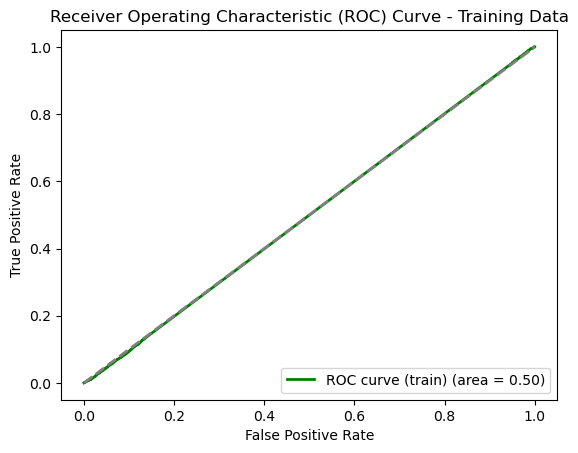

In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Initialize and train the SVM model
model = SVC(probability=True, kernel='linear', max_iter=1000)  
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.6548773531089561
Test Log Loss: 3.4832821749003373
Test ROC AUC: 0.49891992199436624
Test Classification Report:
              precision    recall  f1-score   support

           0       0.11      0.33      0.16      1045
           1       0.90      0.69      0.78      9473

    accuracy                           0.65     10518
   macro avg       0.50      0.51      0.47     10518
weighted avg       0.82      0.65      0.72     10518

Train Accuracy: 0.8176560159147285
Train Log Loss: 0.3452854039126326
Train ROC AUC: 0.9165545258123641
Train Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.91      0.83     40717
           1       0.89      0.73      0.80     40717

    accuracy                           0.82     81434
   macro avg       0.83      0.82      0.82     81434
weighted avg       0.83      0.82      0.82     81434



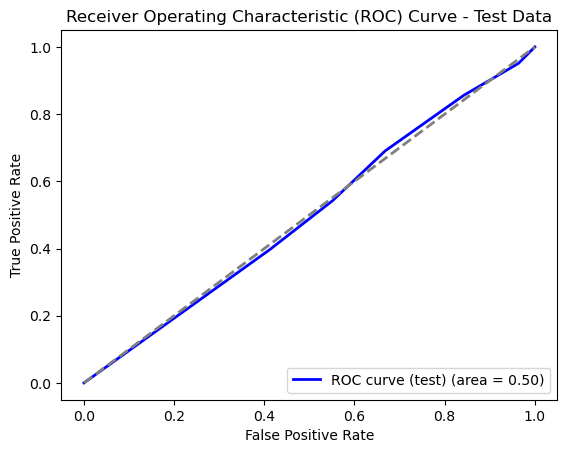

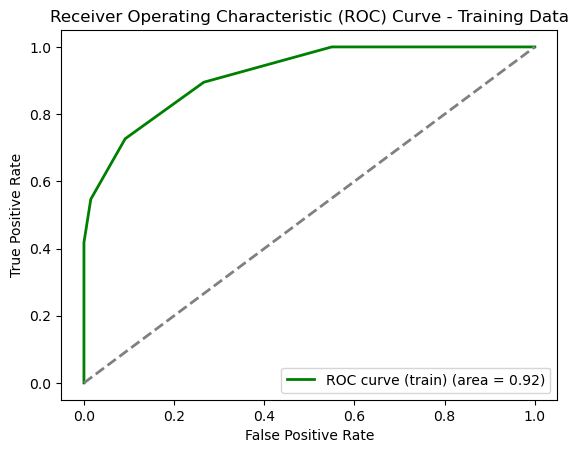

In [17]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier  
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Initialize and train the KNN model
model = KNeighborsClassifier(n_neighbors=5)  
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.504563605248146
Test Log Loss: 1.8301682677229016
Test ROC AUC: 0.5617954225987029
Test Classification Report:
              precision    recall  f1-score   support

           0       0.10      0.53      0.18      1045
           1       0.91      0.50      0.65      9473

    accuracy                           0.50     10518
   macro avg       0.51      0.52      0.41     10518
weighted avg       0.83      0.50      0.60     10518

Train Accuracy: 0.7025935113097723
Train Log Loss: 0.9090946801584339
Train ROC AUC: 0.7863335078638773
Train Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.59      0.66     40717
           1       0.66      0.82      0.73     40717

    accuracy                           0.70     81434
   macro avg       0.71      0.70      0.70     81434
weighted avg       0.71      0.70      0.70     81434



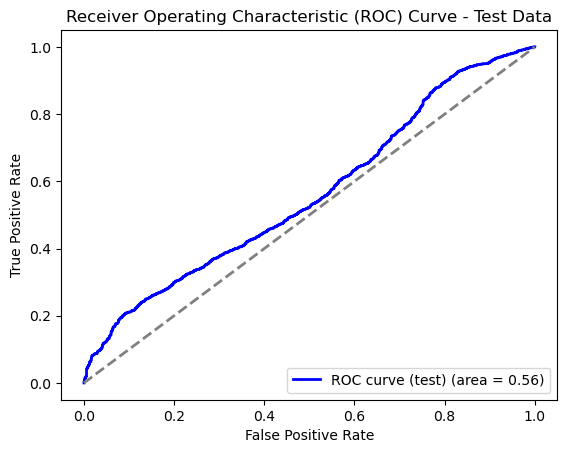

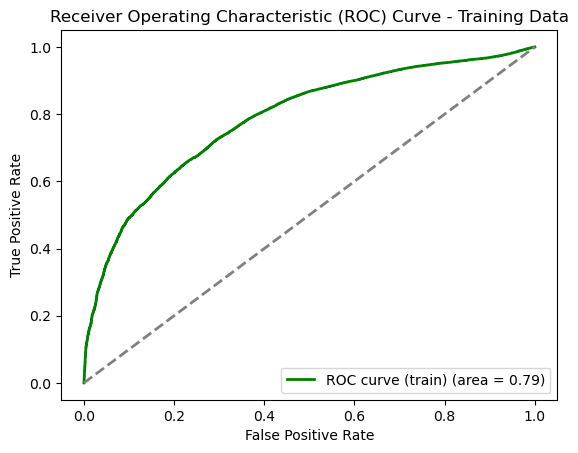

In [18]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB  
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, classification_report, log_loss
import matplotlib.pyplot as plt

# Initialize and train the Naive Bayes model
model = GaussianNB() 
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8253470241490778
Test Log Loss: 0.3487176072679159
Test ROC AUC: 0.7861669807465894
Test Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.43      0.33      1045
           1       0.93      0.87      0.90      9473

    accuracy                           0.83     10518
   macro avg       0.60      0.65      0.61     10518
weighted avg       0.87      0.83      0.84     10518

Train Accuracy: 0.9070658447331581
Train Log Loss: 0.2237066253363857
Train ROC AUC: 0.9708118569913906
Train Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     40717
           1       0.90      0.91      0.91     40717

    accuracy                           0.91     81434
   macro avg       0.91      0.91      0.91     81434
weighted avg       0.91      0.91      0.91     81434



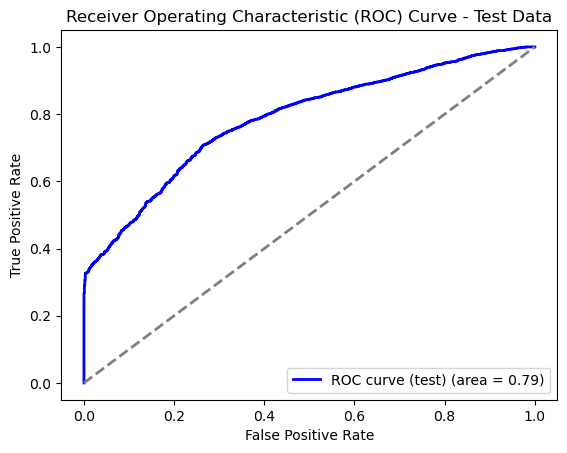

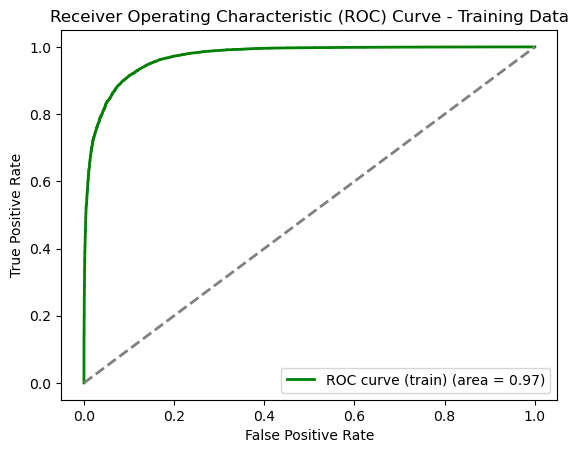

In [19]:
import xgboost as xgb

# XGBoost model
model = xgb.XGBClassifier(
    max_depth=6,                  
    learning_rate=0.1,            
    n_estimators=100,            
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8253470241490778
Test Log Loss: 0.3487176072679159
Test ROC AUC: 0.7861669807465894
Test Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.43      0.33      1045
           1       0.93      0.87      0.90      9473

    accuracy                           0.83     10518
   macro avg       0.60      0.65      0.61     10518
weighted avg       0.87      0.83      0.84     10518

Class 0 Test Accuracy: 0.4296650717703349
Class 1 Test Accuracy: 0.8689960941623561
Train Accuracy: 0.9070658447331581
Train Log Loss: 0.2237066253363857
Train ROC AUC: 0.9708118569913906
Train Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     40717
           1       0.90      0.91      0.91     40717

    accuracy                           0.91     81434
   macro avg       0.91      0.91      0.91     81434
weighted avg       0.91      0.91      0.91     81434



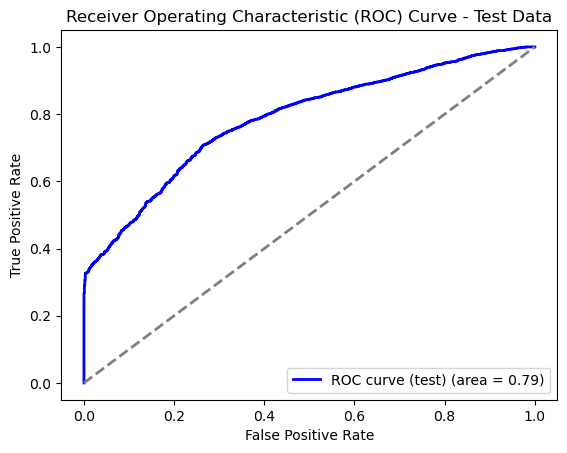

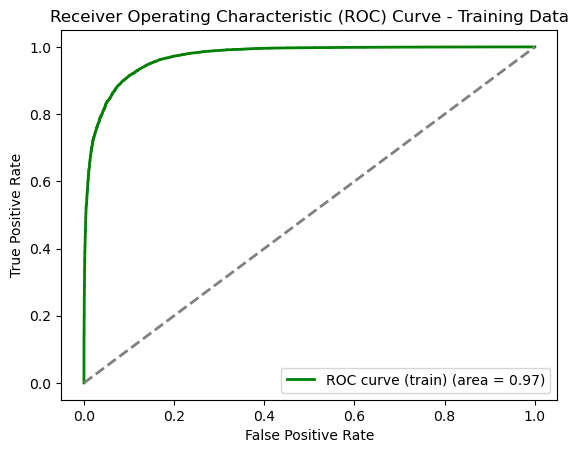

In [20]:
import xgboost as xgb

# XGBoost model
model = xgb.XGBClassifier(
    max_depth=6,                  
    learning_rate=0.1,            
    n_estimators=100,            
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

In [21]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

model = xgb.XGBClassifier(
    max_depth=6,                  
    learning_rate=0.1,            
    n_estimators=100,            
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]), 
    random_state=42
)

# Set up stratified k-fold cross-validation (ensuring class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and capture metrics
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=['accuracy', 'roc_auc', 'neg_log_loss'], return_train_score=True)

# Output the results of cross-validation
print("Cross-Validation Results:")
print(f"Mean Test Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean Test ROC AUC: {cv_results['test_roc_auc'].mean():.4f}")
print(f"Mean Test Log Loss: {-cv_results['test_neg_log_loss'].mean():.4f}")
print(f"Mean Train Accuracy: {cv_results['train_accuracy'].mean():.4f}")
print(f"Mean Train ROC AUC: {cv_results['train_roc_auc'].mean():.4f}")
print(f"Mean Train Log Loss: {-cv_results['train_neg_log_loss'].mean():.4f}")

# Now fit the model on the entire training dataset and evaluate it
model.fit(X_train, y_train)

# Predictions and evaluation metrics as before
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Output the evaluation metrics
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Classification Report:\n{report}")

Cross-Validation Results:
Mean Test Accuracy: 0.8993
Mean Test ROC AUC: 0.9656
Mean Test Log Loss: 0.2389
Mean Train Accuracy: 0.9079
Mean Train ROC AUC: 0.9715
Mean Train Log Loss: 0.2213

Test Accuracy: 0.8253
Test Log Loss: 0.3487
Test ROC AUC: 0.7862
Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.43      0.33      1045
           1       0.93      0.87      0.90      9473

    accuracy                           0.83     10518
   macro avg       0.60      0.65      0.61     10518
weighted avg       0.87      0.83      0.84     10518



Test Accuracy: 0.8253470241490778
Test Log Loss: 0.3487176072679159
Test ROC AUC: 0.7861669807465894
Test Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.43      0.33      1045
           1       0.93      0.87      0.90      9473

    accuracy                           0.83     10518
   macro avg       0.60      0.65      0.61     10518
weighted avg       0.87      0.83      0.84     10518

Class 0 Test Accuracy: 0.4296650717703349
Class 1 Test Accuracy: 0.8689960941623561
Train Accuracy: 0.9070658447331581
Train Log Loss: 0.2237066253363857
Train ROC AUC: 0.9708118569913906
Train Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     40717
           1       0.90      0.91      0.91     40717

    accuracy                           0.91     81434
   macro avg       0.91      0.91      0.91     81434
weighted avg       0.91      0.91      0.91     81434



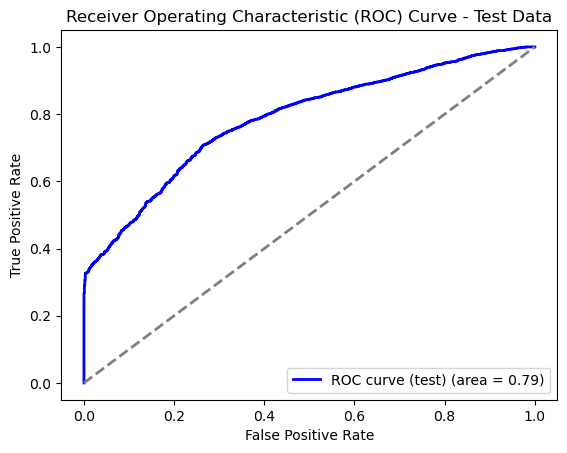

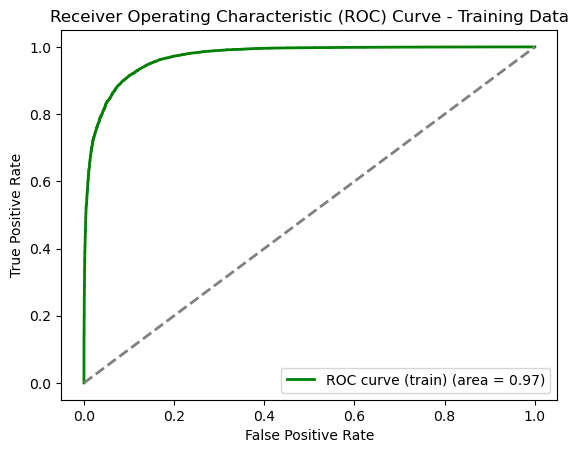

In [22]:
import xgboost as xgb

model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8316219813652785
Test Log Loss: 0.35541047099292455
Test ROC AUC: 0.787412020161052
Test Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.42      0.33      1045
           1       0.93      0.88      0.90      9473

    accuracy                           0.83     10518
   macro avg       0.60      0.65      0.62     10518
weighted avg       0.87      0.83      0.85     10518

Class 0 Test Accuracy: 0.41626794258373206
Class 1 Test Accuracy: 0.8774411485273936
Train Accuracy: 0.9002750693813395
Train Log Loss: 0.2377346750140364
Train ROC AUC: 0.9664618906412018
Train Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.89      0.90     40717
           1       0.90      0.91      0.90     40717

    accuracy                           0.90     81434
   macro avg       0.90      0.90      0.90     81434
weighted avg       0.90      0.90      0.90     81434


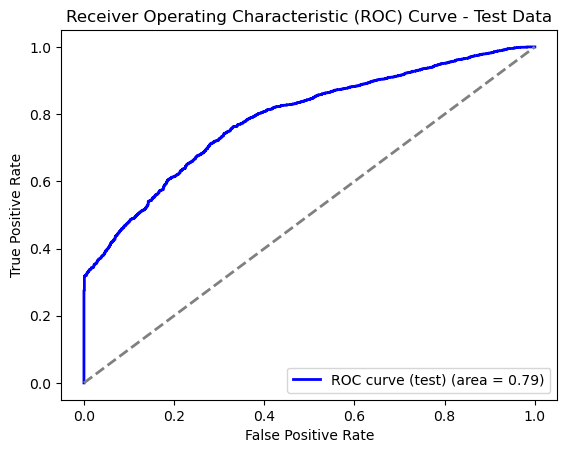

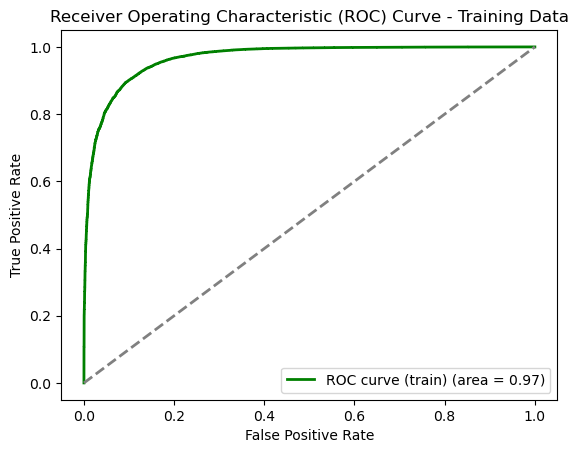

In [23]:
model = xgb.XGBClassifier(
    max_depth=5,                   # Slightly shallower trees
    learning_rate=0.05,            # Slower learning rate
    n_estimators=200,              # More boosting rounds
    subsample=0.8,                 # Use 80% of data for each tree
    colsample_bytree=0.8,          # Use 80% of features for each tree
    scale_pos_weight=len(y_train[y_train == 0]) / len(y_train[y_train == 1]),  # Handle class imbalance
    gamma=0.1,                     # Regularization to prevent overfitting
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8313367560372694
Test Log Loss: 0.3508686973150177
Test ROC AUC: 0.8025700846071206
Test Classification Report:
              precision    recall  f1-score   support

           0       0.29      0.47      0.36      1045
           1       0.94      0.87      0.90      9473

    accuracy                           0.83     10518
   macro avg       0.61      0.67      0.63     10518
weighted avg       0.87      0.83      0.85     10518

Class 0 Test Accuracy: 0.47368421052631576
Class 1 Test Accuracy: 0.8707906682149267
Train Accuracy: 0.908379792224378
Train Log Loss: 0.21953062174613233
Train ROC AUC: 0.9721933406729297
Train Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.91     40717
           1       0.90      0.92      0.91     40717

    accuracy                           0.91     81434
   macro avg       0.91      0.91      0.91     81434
weighted avg       0.91      0.91      0.91     81434


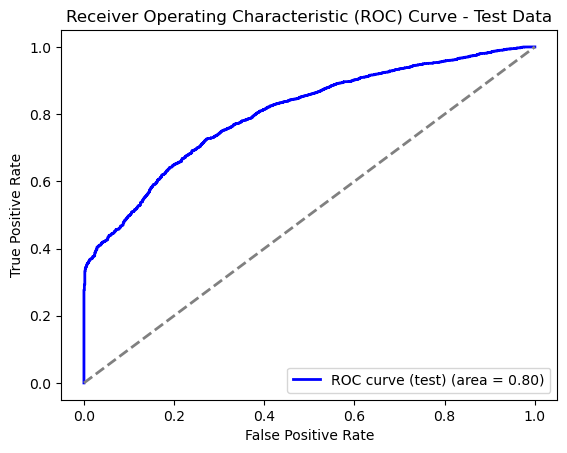

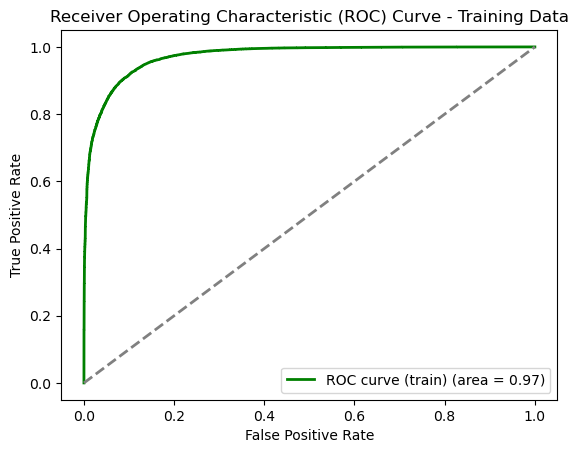

In [24]:
model = xgb.XGBClassifier(
    max_depth=6,
    learning_rate=0.1,
    n_estimators=100,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0.1,  # L1 regularization
    reg_lambda=1.0,  # L2 regularization
    random_state=42
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
print(f"Cross-Validation AUC Scores: {cv_scores}")
print(f"Mean Cross-Validation AUC Score: {np.mean(cv_scores)}")


Test Accuracy: 0.8119414337326488
Test Log Loss: 0.3617443973156231
Test ROC AUC: 0.7777045008806192
Test Classification Report:
              precision    recall  f1-score   support

           0       0.25      0.44      0.32      1045
           1       0.93      0.85      0.89      9473

    accuracy                           0.81     10518
   macro avg       0.59      0.64      0.60     10518
weighted avg       0.86      0.81      0.83     10518

Class 0 Test Accuracy: 0.4354066985645933
Class 1 Test Accuracy: 0.8534783067665999
Train Accuracy: 0.9034678389861729
Train Log Loss: 0.23637408857299524
Train ROC AUC: 0.9672576311071113
Train Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90     40717
           1       0.90      0.91      0.90     40717

    accuracy                           0.90     81434
   macro avg       0.90      0.90      0.90     81434
weighted avg       0.90      0.90      0.90     81434


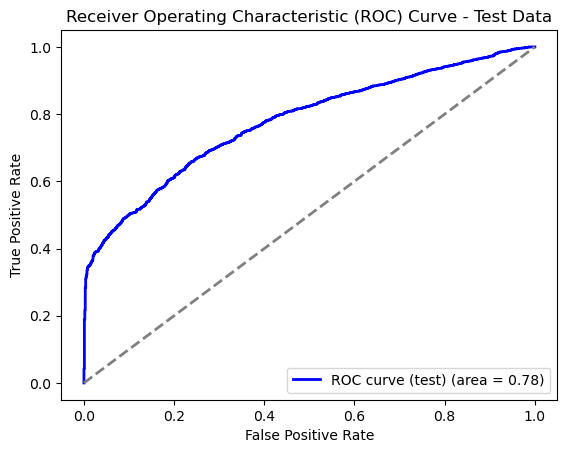

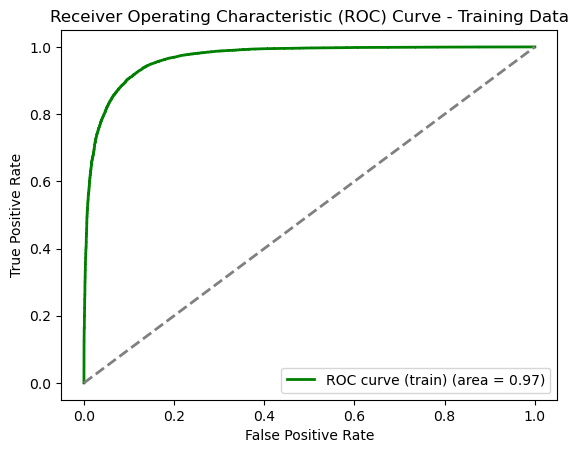

In [25]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# GBM model
model = GradientBoostingClassifier(
    max_depth=5,                    # Same depth as XGBoost for comparison
    learning_rate=0.05,             # Learning rate
    n_estimators=200,               # Number of boosting rounds
    subsample=0.8,                  # Use 80% of data for each tree
    random_state=42                 # Random state for reproducibility
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8390378398935159
Test Log Loss: 0.3478031114759678
Test ROC AUC: 0.7851214001819323
Test Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.35      0.30      1045
           1       0.93      0.89      0.91      9473

    accuracy                           0.84     10518
   macro avg       0.60      0.62      0.61     10518
weighted avg       0.86      0.84      0.85     10518

Class 0 Test Accuracy: 0.35119617224880384
Class 1 Test Accuracy: 0.892853372743587
Train Accuracy: 0.898420807033917
Train Log Loss: 0.2488323012337347
Train ROC AUC: 0.9627933967306248
Train Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     40717
           1       0.89      0.91      0.90     40717

    accuracy                           0.90     81434
   macro avg       0.90      0.90      0.90     81434
weighted avg       0.90      0.90      0.90     81434

C

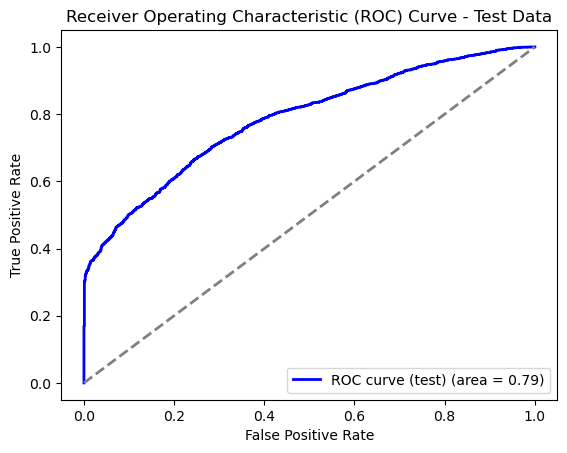

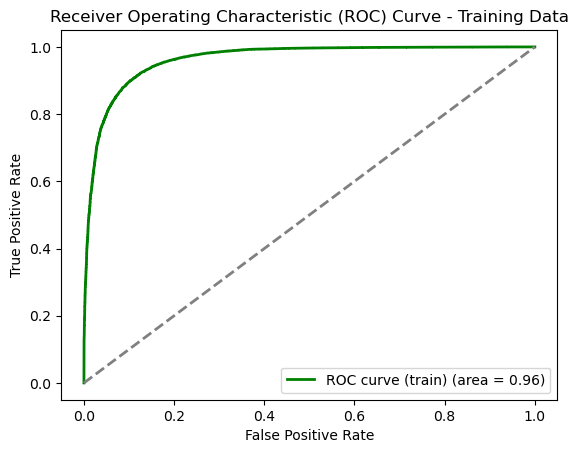

In [26]:
from sklearn.ensemble import GradientBoostingClassifier

model = GradientBoostingClassifier(
    max_depth=5,
    learning_rate=0.05,
    n_estimators=200,
    subsample=0.8,
    random_state=42,
    min_samples_split=10,
    min_samples_leaf=5,
    max_features='sqrt',
    warm_start=False,
    validation_fraction=0.1,
    n_iter_no_change=10,
    tol=1e-4
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.8508271534512265
Test Log Loss: 0.36355881458910455
Test ROC AUC: 0.7747883811810651
Test Classification Report:
              precision    recall  f1-score   support

           0       0.27      0.30      0.29      1045
           1       0.92      0.91      0.92      9473

    accuracy                           0.85     10518
   macro avg       0.60      0.61      0.60     10518
weighted avg       0.86      0.85      0.85     10518

Class 0 Test Accuracy: 0.3033492822966507
Class 1 Test Accuracy: 0.9112213659875436
Train Accuracy: 0.9137092614878306
Train Log Loss: 0.21661600654850685
Train ROC AUC: 0.9730418095098173
Train Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.91      0.91     40717
           1       0.91      0.92      0.91     40717

    accuracy                           0.91     81434
   macro avg       0.91      0.91      0.91     81434
weighted avg       0.91      0.91      0.91     81434

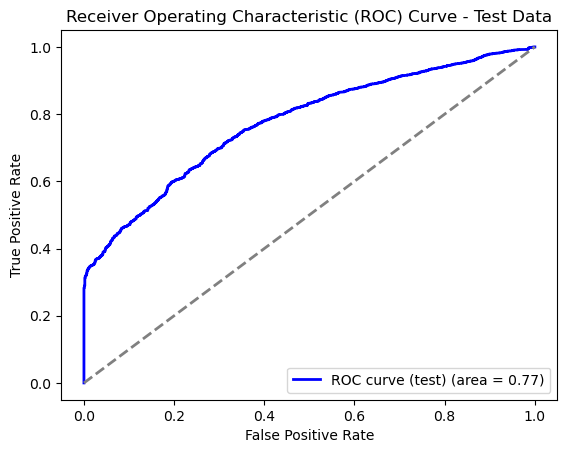

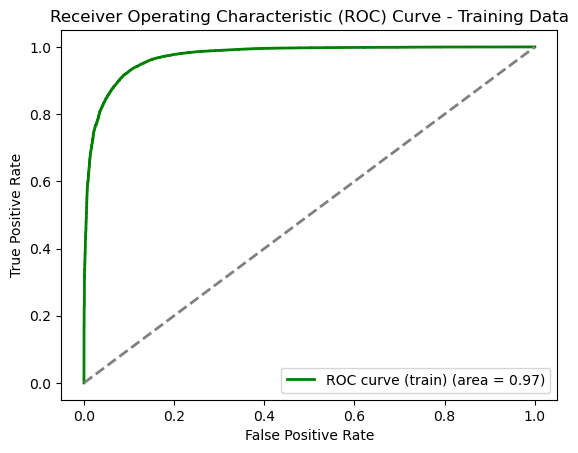

In [27]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, roc_curve
import matplotlib.pyplot as plt

# GBM model
model = GradientBoostingClassifier(
    max_depth=6,                    
    learning_rate=0.1,              
    n_estimators=100,              
    random_state=42                 
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()


c:\Users\Admin\anaconda3\Lib\site-packages\sklearn\ensemble\_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Test Accuracy: 0.757843696520251
Test Log Loss: 0.509566941314896
Test ROC AUC: 0.6262753825149998
Test Classification Report:
              precision    recall  f1-score   support

           0       0.17      0.36      0.23      1045
           1       0.92      0.80      0.86      9473

    accuracy                           0.76     10518
   macro avg       0.54      0.58      0.54     10518
weighted avg       0.84      0.76      0.79     10518

Class 0 Test Accuracy: 0.3559808612440191
Class 1 Test Accuracy: 0.8021746014989971
Train Accuracy: 0.9203158385932166
Train Log Loss: 0.4967184628402215
Train ROC AUC: 0.9809035247549489
Train Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.91      0.92     40717
           1       0.91      0.93      0.92     40717

    accuracy                           0.92     81434
   macro avg       0.92      0.92      0.92     81434
weighted avg       0.92      0.92      0.92     81434

Cl

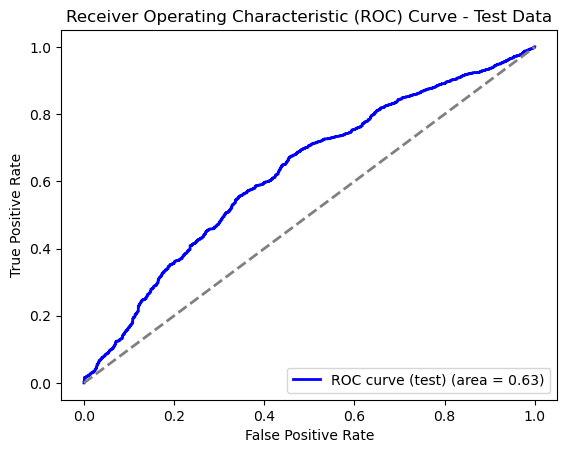

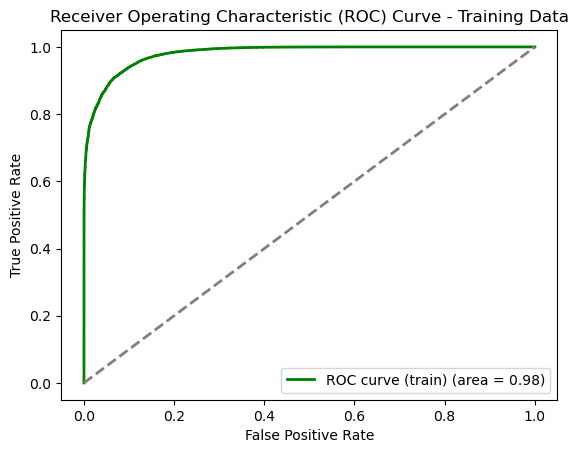

In [28]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# AdaBoost model with a DecisionTreeClassifier as the base estimator
model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=6),  
    learning_rate=0.1,                              
    n_estimators=100,                               
    random_state=42                                 
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

Test Accuracy: 0.7427267541357673
Test Log Loss: 0.4710305193931693
Test ROC AUC: 0.8094794219986594
Test Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.70      0.35      1045
           1       0.96      0.75      0.84      9473

    accuracy                           0.74     10518
   macro avg       0.60      0.72      0.59     10518
weighted avg       0.89      0.74      0.79     10518

Class 0 Test Accuracy: 0.6976076555023923
Class 1 Test Accuracy: 0.7477040008445054
Train Accuracy: 0.8963700665569664
Train Log Loss: 0.25035763664754906
Train ROC AUC: 0.9618419209759421
Train Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.89      0.90     40717
           1       0.89      0.90      0.90     40717

    accuracy                           0.90     81434
   macro avg       0.90      0.90      0.90     81434
weighted avg       0.90      0.90      0.90     81434


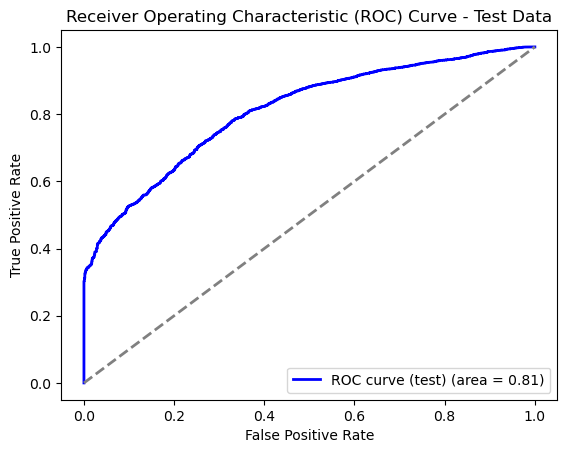

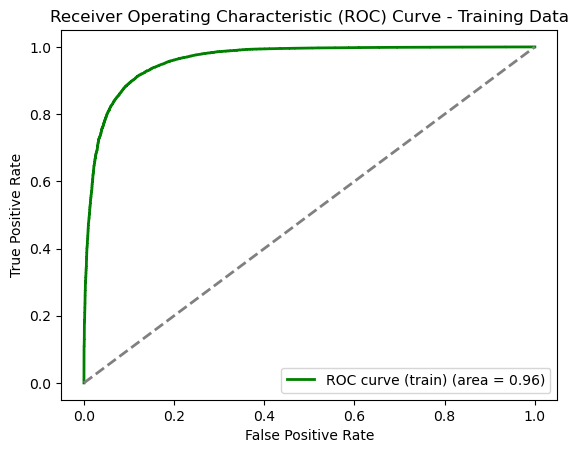

In [29]:
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# CatBoost model
model = CatBoostClassifier(
    depth=6,                      
    learning_rate=0.1,            
    iterations=100,               
    random_seed=42,               
    verbose=0                     
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 40717, number of negative: 40717
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012080 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 3697
[LightGBM] [Info] Number of data points in the train set: 81434, number of used features: 35
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Test Accuracy: 0.83466438486404

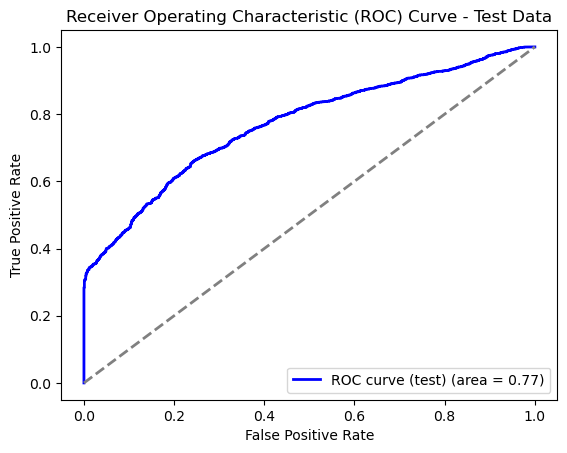

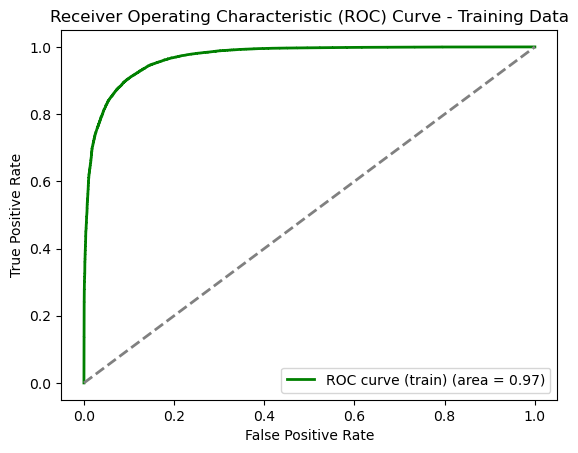

In [30]:
from lightgbm import LGBMClassifier
from sklearn.metrics import accuracy_score, log_loss, roc_auc_score, classification_report, confusion_matrix, roc_curve
import matplotlib.pyplot as plt

# LightGBM model
model = LGBMClassifier(
    max_depth=6,                     # Equivalent to max_depth in AdaBoost
    learning_rate=0.1,               # Same learning rate as AdaBoost
    n_estimators=100,                # Equivalent to n_estimators
    random_state=42                  # Random state for reproducibility
)

# Fit the model on training data
model.fit(X_train, y_train)

# Make predictions on test and training data
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

y_train_pred = model.predict(X_train)
y_train_pred_proba = model.predict_proba(X_train)[:, 1]

# Evaluate the model on test data
accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Evaluate the model on training data
train_accuracy = accuracy_score(y_train, y_train_pred)
train_log_loss = log_loss(y_train, y_train_pred_proba)
train_roc_auc = roc_auc_score(y_train, y_train_pred_proba)
train_report = classification_report(y_train, y_train_pred)

# Calculate confusion matrix for test data and compute class-specific accuracy
conf_matrix_test = confusion_matrix(y_test, y_pred)
class_0_accuracy_test = conf_matrix_test[0, 0] / conf_matrix_test[0].sum()
class_1_accuracy_test = conf_matrix_test[1, 1] / conf_matrix_test[1].sum()

# Calculate confusion matrix for training data and compute class-specific accuracy
conf_matrix_train = confusion_matrix(y_train, y_train_pred)
class_0_accuracy_train = conf_matrix_train[0, 0] / conf_matrix_train[0].sum()
class_1_accuracy_train = conf_matrix_train[1, 1] / conf_matrix_train[1].sum()

# Print evaluation metrics for test and training data
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")
print(f"Class 0 Test Accuracy: {class_0_accuracy_test}")
print(f"Class 1 Test Accuracy: {class_1_accuracy_test}")

print(f"Train Accuracy: {train_accuracy}")
print(f"Train Log Loss: {train_log_loss}")
print(f"Train ROC AUC: {train_roc_auc}")
print(f"Train Classification Report:\n{train_report}")
print(f"Class 0 Train Accuracy: {class_0_accuracy_train}")
print(f"Class 1 Train Accuracy: {class_1_accuracy_train}")

# Plot ROC curve for test data
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (test) (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Test Data')
plt.legend(loc="lower right")
plt.show()

# Plot ROC curve for training data
fpr_train, tpr_train, _ = roc_curve(y_train, y_train_pred_proba)
plt.figure()
plt.plot(fpr_train, tpr_train, color='green', lw=2, label=f'ROC curve (train) (area = {train_roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve - Training Data')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Convert data to numeric types
X_train_numeric = np.array(X_train, dtype=np.float32)  
X_test_numeric = np.array(X_test, dtype=np.float32)    
y_train_numeric = np.array(y_train, dtype=np.float32)  
y_test_numeric = np.array(y_test, dtype=np.float32)    

# Reshape X_train and X_test to have a time step dimension (convert to 3D for RNN input)
X_train_reshaped = np.expand_dims(X_train_numeric, axis=1)  
X_test_reshaped = np.expand_dims(X_test_numeric, axis=1)

# Define the Simple RNN model
model = Sequential([
    SimpleRNN(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train_reshaped, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_numeric))

# Make predictions
y_pred_proba = model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Check for NaN values in y_pred_proba or y_test_numeric
if np.isnan(y_pred_proba).any() or np.isnan(y_test_numeric).any():
    print("NaN values found in predictions or test labels.")
    y_pred_proba = np.nan_to_num(y_pred_proba)  
    y_test_numeric = np.nan_to_num(y_test_numeric)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
log_loss_value = log_loss(y_test_numeric, y_pred_proba)
roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
report = classification_report(y_test_numeric, y_pred)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

# Training accuracy and loss
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Loss: {train_loss}")

# Plot training & validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt

# Define the LSTM model
model = Sequential([
    LSTM(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train_reshaped, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_numeric))

# Make predictions
y_pred_proba = model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Check for NaN values in y_pred_proba or y_test_numeric
if np.isnan(y_pred_proba).any() or np.isnan(y_test_numeric).any():
    print("NaN values found in predictions or test labels.")
    y_pred_proba = np.nan_to_num(y_pred_proba) 
    y_test_numeric = np.nan_to_num(y_test_numeric)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
log_loss_value = log_loss(y_test_numeric, y_pred_proba)
roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
report = classification_report(y_test_numeric, y_pred)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

# Training accuracy and loss
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Loss: {train_loss}")

# Plot training & validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import accuracy_score, log_loss, roc_curve, roc_auc_score, classification_report
import matplotlib.pyplot as plt


# Define the GRU model
model = Sequential([
    GRU(32, input_shape=(X_train_reshaped.shape[1], X_train_reshaped.shape[2]), activation='relu', return_sequences=False),
    Dropout(0.2),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])

# Train the model and store history
history = model.fit(X_train_reshaped, y_train_numeric, epochs=20, batch_size=32, validation_data=(X_test_reshaped, y_test_numeric))

# Make predictions
y_pred_proba = model.predict(X_test_reshaped).ravel()
y_pred = (y_pred_proba > 0.5).astype(int)

# Check for NaN values in y_pred_proba or y_test_numeric
if np.isnan(y_pred_proba).any() or np.isnan(y_test_numeric).any():
    print("NaN values found in predictions or test labels.")
    y_pred_proba = np.nan_to_num(y_pred_proba)  
    y_test_numeric = np.nan_to_num(y_test_numeric)

# Evaluate the model
accuracy = accuracy_score(y_test_numeric, y_pred)
log_loss_value = log_loss(y_test_numeric, y_pred_proba)
roc_auc = roc_auc_score(y_test_numeric, y_pred_proba)
report = classification_report(y_test_numeric, y_pred)

# Print evaluation metrics
print(f"Test Accuracy: {accuracy}")
print(f"Test Log Loss: {log_loss_value}")
print(f"Test ROC AUC: {roc_auc}")
print(f"Test Classification Report:\n{report}")

# Training accuracy and loss
train_accuracy = history.history['accuracy'][-1]
train_loss = history.history['loss'][-1]
print(f"Training Accuracy: {train_accuracy}")
print(f"Training Loss: {train_loss}")

# Plot training & validation accuracy over epochs
plt.figure()
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot training & validation loss over epochs
plt.figure()
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test_numeric, y_pred_proba)
plt.figure()
plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(X_train.dtypes)

In [ ]:
from sklearn.model_selection import cross_val_score, cross_validate, StratifiedKFold

# Define the AdaBoost model with a DecisionTreeClassifier as base estimator
model = AdaBoostClassifier(
    estimator=DecisionTreeClassifier(max_depth=6),  # Mimicking max_depth of 6 like in XGBoost
    learning_rate=0.1,                              # Equivalent to XGBoost learning rate
    n_estimators=100,                               # Number of boosting rounds, same as XGBoost
    random_state=42                                 # Random state for reproducibility
)

# Set up stratified k-fold cross-validation (ensuring class balance in folds)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation and capture metrics
cv_results = cross_validate(model, X_train, y_train, cv=cv, scoring=['accuracy', 'roc_auc', 'neg_log_loss'], return_train_score=True)

# Output the results of cross-validation
print("Cross-Validation Results:")
print(f"Mean Test Accuracy: {cv_results['test_accuracy'].mean():.4f}")
print(f"Mean Test ROC AUC: {cv_results['test_roc_auc'].mean():.4f}")
print(f"Mean Test Log Loss: {-cv_results['test_neg_log_loss'].mean():.4f}")
print(f"Mean Train Accuracy: {cv_results['train_accuracy'].mean():.4f}")
print(f"Mean Train ROC AUC: {cv_results['train_roc_auc'].mean():.4f}")
print(f"Mean Train Log Loss: {-cv_results['train_neg_log_loss'].mean():.4f}")

# Now fit the model on the entire training dataset and evaluate it
model.fit(X_train, y_train)

# Predictions and evaluation metrics as before
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

accuracy = accuracy_score(y_test, y_pred)
log_loss_value = log_loss(y_test, y_pred_proba)
roc_auc = roc_auc_score(y_test, y_pred_proba)
report = classification_report(y_test, y_pred)

# Output the evaluation metrics
print(f"\nTest Accuracy: {accuracy:.4f}")
print(f"Test Log Loss: {log_loss_value:.4f}")
print(f"Test ROC AUC: {roc_auc:.4f}")
print(f"Classification Report:\n{report}")